In [1]:
!unzip /content/news+aggregator.zip

Archive:  /content/news+aggregator.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
#50
import pandas as pd
from sklearn.model_selection import train_test_split

#ファイルを読み込む
df = pd.read_csv("newsCorpora.csv", sep="\t", header=None,
                 names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

#各カラムのデータ数、欠損値、オブジェクトを確認する
df.info()

#情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する
df = df[df["PUBLISHER"].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])]
df = df[["TITLE", "CATEGORY"]]

#学習、検証、評価データに分割する
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123)  # 80%:20%
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123)  # 10%:10%

#学習、検証、評価データをファイルに保存する
train.to_csv("train.txt", sep="\t", index=False, header=None)
valid.to_csv("valid.txt", sep="\t", index=False, header=None)
test.to_csv("test.txt", sep="\t", index=False, header=None)

print("\n【CATEGORYの事例数】")
print("学習データ\n", "-"*50,"\n", train["CATEGORY"].value_counts())
print()
print("検証データ\n", "-"*50,"\n", valid["CATEGORY"].value_counts())
print()
print("評価データ\n", "-"*50,"\n", test["CATEGORY"].value_counts())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         422419 non-null  int64 
 1   TITLE      422419 non-null  object
 2   URL        422419 non-null  object
 3   PUBLISHER  422417 non-null  object
 4   CATEGORY   422419 non-null  object
 5   STORY      422419 non-null  object
 6   HOSTNAME   422419 non-null  object
 7   TIMESTAMP  422419 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 25.8+ MB

【CATEGORYの事例数】
学習データ
 -------------------------------------------------- 
 CATEGORY
b    4481
e    4262
t    1190
m     739
Name: count, dtype: int64

検証データ
 -------------------------------------------------- 
 CATEGORY
b    568
e    513
t    164
m     89
Name: count, dtype: int64

評価データ
 -------------------------------------------------- 
 CATEGORY
b    578
e    504
t    170
m     82
Name: count, dtype: int64


In [3]:
#51
import pandas as pd
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# 前処理（関数
def preprocessing(text):
  text = "".join([i for i in text if i not in string.punctuation])
  text = text.lower()
  text = re.sub("[0-9]+", "", text)
  return text

# ファイルの読み込み
train = pd.read_csv("train.txt", sep="\t", header=None, names=["TITLE", "CATEGORY"])
valid = pd.read_csv("valid.txt", sep="\t", header=None, names=["TITLE", "CATEGORY"])
test = pd.read_csv("test.txt", sep="\t", header=None, names=["TITLE", "CATEGORY"])


# 各データに前処理を適用
train["TITLE"] = train["TITLE"].map(lambda x: preprocessing(x))
valid["TITLE"] = valid["TITLE"].map(lambda x: preprocessing(x))
test["TITLE"] = test["TITLE"].map(lambda x: preprocessing(x))

# TF-IDFベクトル化（stop_words=None）
vec_tfidf = TfidfVectorizer(stop_words=None)

# 学習データ、検証データ、評価データに対してTF-IDFを計算
x_train_tfidf = vec_tfidf.fit_transform(train["TITLE"])
x_valid_tfidf = vec_tfidf.transform(valid["TITLE"])
x_test_tfidf = vec_tfidf.transform(test["TITLE"])

# DataFrameに変換
x_train = pd.DataFrame(x_train_tfidf.toarray(), columns=vec_tfidf.get_feature_names_out())
x_valid = pd.DataFrame(x_valid_tfidf.toarray(), columns=vec_tfidf.get_feature_names_out())
x_test = pd.DataFrame(x_test_tfidf.toarray(), columns=vec_tfidf.get_feature_names_out())

# 特徴量をファイルに保存
x_train.to_csv('train.feature.txt', sep='\t', index=False)
x_valid.to_csv('valid.feature.txt', sep='\t', index=False)
x_test.to_csv('test.feature.txt', sep='\t', index=False)

print("特徴量の抽出と保存が完了しました。")


特徴量の抽出と保存が完了しました。


In [4]:
#52
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 特徴量ファイルとラベルファイルの読み込み
x_train = pd.read_csv("train.feature.txt", sep='\t')
y_train = pd.read_csv("train.txt", sep="\t", header=None, names=["CATEGORY"])["CATEGORY"]

# モデルの作成
model = LogisticRegression(max_iter=1000)  # max_iterは収束までの最大反復回数

# モデルの学習
model.fit(x_train, y_train)
print("学習が終了")

学習が終了


In [5]:
#53
import pandas as pd
from sklearn.linear_model import LogisticRegression
x_valid = pd.read_csv("valid.feature.txt", sep='\t')

# 検証データのカテゴリ（実際のカテゴリラベルを読み込む）
y_valid = pd.read_csv("valid.txt", sep="\t", header=None, names=["CATEGORY"])["CATEGORY"]

# ロジスティック回帰モデルを使用して予測
print(f"カテゴリ順：{model.classes_}\n")

# カテゴリの予測（ラベル）
Y_pred = model.predict(x_valid)
print(f"各記事のカテゴリ（ラベル）：\n{y_valid.values[:5]}")  # 実際のカテゴリラベル（最初の5つ）
print(f"各記事のカテゴリ予測：\n{Y_pred[:5]}\n")  # モデルによる予測カテゴリ（最初の5つ）

# カテゴリの予測確率
Y_pred_prob = model.predict_proba(x_valid)
print(f"カテゴリの予測確率（最初の5つの記事）：\n{Y_pred_prob[:5]}")


カテゴリ順：['b' 'e' 'm' 't']

各記事のカテゴリ（ラベル）：
['e' 'm' 't' 'b' 'b']
各記事のカテゴリ予測：
['e' 'm' 't' 'b' 'b']

カテゴリの予測確率（最初の5つの記事）：
[[0.16209162 0.72284964 0.04768133 0.06737741]
 [0.3540311  0.1157078  0.47093252 0.05932858]
 [0.17075477 0.0904447  0.04596087 0.69283966]
 [0.81462807 0.10256929 0.02786575 0.05493689]
 [0.76329074 0.08654439 0.03845946 0.11170541]]


In [6]:
#54
from sklearn.metrics import accuracy_score

# 評価データのカテゴリ（実際のカテゴリラベルを読み込む）
y_test = pd.read_csv("test.txt", sep="\t", header=None, names=["TITLE", "CATEGORY"])["CATEGORY"]

# 学習データに対する予測と正解率
y_train_pred = model.predict(x_train)  # 学習データに対する予測
train_accuracy = accuracy_score(y_train, y_train_pred)  # 正解率の計算
print(f"学習データの正解率: {train_accuracy:.4f}")

# 評価データに対する予測と正解率
y_test_pred = model.predict(x_test)  # 評価データに対する予測
test_accuracy = accuracy_score(y_test, y_test_pred)  # 正解率の計算
print(f"評価データの正解率: {test_accuracy:.4f}")


学習データの正解率: 0.9421
評価データの正解率: 0.8853


In [7]:
#55
from sklearn.metrics import confusion_matrix

# 学習データに対する予測と混同行列
y_train_pred = model.predict(x_train)  # 学習データに対する予測
train_conf_matrix = confusion_matrix(y_train, y_train_pred)  # 学習データの混同行列
print(f"学習データの混同行列：\n{train_conf_matrix}\n")

# 評価データに対する予測と混同行列
y_test_pred = model.predict(x_test)  # 評価データに対する予測
test_conf_matrix = confusion_matrix(y_test, y_test_pred)  # 評価データの混同行列
print(f"評価データの混同行列：\n{test_conf_matrix}")

学習データの混同行列：
[[4403   52    2   24]
 [  23 4237    0    2]
 [  92  126  519    2]
 [ 169  125    1  895]]

評価データの混同行列：
[[549  19   1   9]
 [ 11 491   0   2]
 [ 20  18  41   3]
 [ 39  29   2 100]]


In [8]:
#56
from sklearn.metrics import precision_score, recall_score, f1_score

# 評価データに対する予測
y_test_pred = model.predict(x_test)

# 各カテゴリごとの適合率、再現率、F1スコアを計算（カテゴリごとにスコアを表示）
print("カテゴリごとの適合率、再現率、F1スコア:")
for category in model.classes_:
    precision = precision_score(y_test, y_test_pred, labels=[category], average=None)  # 各カテゴリごとのスコア
    recall = recall_score(y_test, y_test_pred, labels=[category], average=None)
    f1 = f1_score(y_test, y_test_pred, labels=[category], average=None)
    print(f"カテゴリ {category}:")
    print(f"  適合率: {precision[0]:.4f}")  # 配列の最初の要素を取り出して表示
    print(f"  再現率: {recall[0]:.4f}")     # 配列の最初の要素を取り出して表示
    print(f"  F1スコア: {f1[0]:.4f}")      # 配列の最初の要素を取り出して表示
    print()

# マイクロ平均（micro-average）とマクロ平均（macro-average）で統合した適合率、再現率、F1スコアを計算
micro_precision = precision_score(y_test, y_test_pred, average='micro')
micro_recall = recall_score(y_test, y_test_pred, average='micro')
micro_f1 = f1_score(y_test, y_test_pred, average='micro')

macro_precision = precision_score(y_test, y_test_pred, average='macro')
macro_recall = recall_score(y_test, y_test_pred, average='macro')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')

# 結果の表示
print(f"マイクロ平均（micro-average）:")
print(f"  適合率: {micro_precision:.4f}")
print(f"  再現率: {micro_recall:.4f}")
print(f"  F1スコア: {micro_f1:.4f}")

print(f"マクロ平均（macro-average）:")
print(f"  適合率: {macro_precision:.4f}")
print(f"  再現率: {macro_recall:.4f}")
print(f"  F1スコア: {macro_f1:.4f}")



カテゴリごとの適合率、再現率、F1スコア:
カテゴリ b:
  適合率: 0.8869
  再現率: 0.9498
  F1スコア: 0.9173

カテゴリ e:
  適合率: 0.8815
  再現率: 0.9742
  F1スコア: 0.9255

カテゴリ m:
  適合率: 0.9318
  再現率: 0.5000
  F1スコア: 0.6508

カテゴリ t:
  適合率: 0.8772
  再現率: 0.5882
  F1スコア: 0.7042

マイクロ平均（micro-average）:
  適合率: 0.8853
  再現率: 0.8853
  F1スコア: 0.8853
マクロ平均（macro-average）:
  適合率: 0.8944
  再現率: 0.7531
  F1スコア: 0.7995


In [9]:
#57
import numpy as np
import pandas as pd

# モデルの重み（係数）を取得
coefficients = model.coef_[0]  # 二項分類の場合、[0] で最初のクラスの係数を取得

# 特徴量名を取得（これはTF-IDFで学習した特徴量名）
feature_names = np.array(vec_tfidf.get_feature_names_out())

# 重みの高いトップ10特徴量
top_10_positive_idx = coefficients.argsort()[-10:][::-1]  # 高い順に並べ替え
top_10_negative_idx = coefficients.argsort()[:10]  # 低い順に並べ替え

top_10_positive = [(feature_names[i], coefficients[i]) for i in top_10_positive_idx]
top_10_negative = [(feature_names[i], coefficients[i]) for i in top_10_negative_idx]

# 結果を表示
print("重みの高い特徴量トップ10:")
for feature, weight in top_10_positive:
    print(f"{feature}: {weight:.4f}")

print("\n重みの低い特徴量トップ10:")
for feature, weight in top_10_negative:
    print(f"{feature}: {weight:.4f}")


重みの高い特徴量トップ10:
bank: 3.3320
fed: 3.1046
ecb: 2.9448
china: 2.7929
oil: 2.6773
ukraine: 2.5897
update: 2.5883
euro: 2.5537
profit: 2.4612
stocks: 2.4075

重みの低い特徴量トップ10:
and: -2.3393
ebola: -1.9525
her: -1.9310
the: -1.9232
video: -1.8212
she: -1.7644
study: -1.7078
facebook: -1.6443
apple: -1.6245
kardashian: -1.6110


In [ ]:
import pandas as pd
x_train = pd.read_csv("train.feature.txt", sep='\t')
y_train = pd.read_csv("train.txt", sep="\t", header=None, names=["CATEGORY"])["CATEGORY"]

x_valid = pd.read_csv("valid.feature.txt", sep='\t')
y_valid = pd.read_csv("valid.txt", sep="\t", header=None, names=["CATEGORY"])["CATEGORY"]

x_test = pd.read_csv("test.feature.txt", sep='\t')
y_test = pd.read_csv("test.txt", sep="\t", header=None, names=["CATEGORY"])["CATEGORY"]


【正則化パラメータ：0.0010】
train_accuracy：0.4303
valid_accuracy：0.4378
test_accuracy：0.4475

【正則化パラメータ：0.0046】
train_accuracy：0.6490
valid_accuracy：0.6544
test_accuracy：0.6364

【正則化パラメータ：0.0215】
train_accuracy：0.7660
valid_accuracy：0.7639
test_accuracy：0.7519

【正則化パラメータ：0.1000】
train_accuracy：0.7797
valid_accuracy：0.7706
test_accuracy：0.7676

【正則化パラメータ：0.4642】
train_accuracy：0.8607
valid_accuracy：0.8388
test_accuracy：0.8306

【正則化パラメータ：2.1544】
train_accuracy：0.9601
valid_accuracy：0.8913
test_accuracy：0.8936

【正則化パラメータ：10.0000】
train_accuracy：0.9964
valid_accuracy：0.9168
test_accuracy：0.9153

【正則化パラメータ：46.4159】
train_accuracy：0.9992
valid_accuracy：0.9190
test_accuracy：0.9145

【正則化パラメータ：215.4435】
train_accuracy：0.9993
valid_accuracy：0.9213
test_accuracy：0.9160

【正則化パラメータ：1000.0000】
train_accuracy：0.9993
valid_accuracy：0.9205
test_accuracy：0.9160



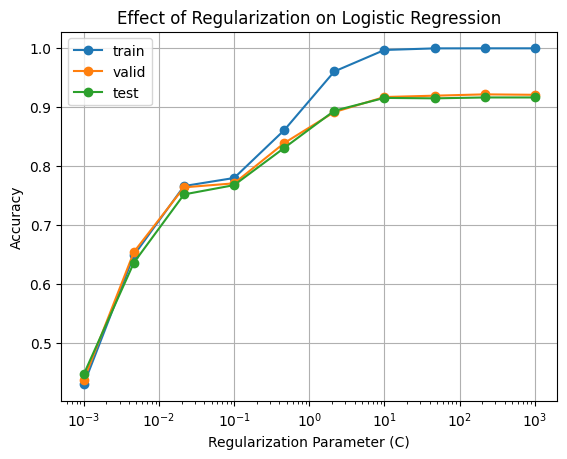

In [10]:
#58
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# モデル構築・学習関数
def LR_model_fit(x_data, y_data, c):
    model = LogisticRegression(C=c, max_iter=1000, solver='liblinear')
    model.fit(x_data, y_data)
    return model

# 予測・精度計算関数
def LR_pred(x_data, y_data, model):
    Y_pred_data = model.predict(x_data)
    accuracy = accuracy_score(y_data, Y_pred_data)
    return accuracy

train_acc = []
valid_acc = []
test_acc = []

# 正則化パラメータ
c_list = np.logspace(-3, 3, 10)

for c in c_list:
    model = LR_model_fit(x_train, y_train, c)
    pre_train = LR_pred(x_train, y_train, model)
    pre_valid = LR_pred(x_valid, y_valid, model)
    pre_test = LR_pred(x_test, y_test, model)

    train_acc.append(pre_train)
    valid_acc.append(pre_valid)
    test_acc.append(pre_test)

    print(f"【正則化パラメータ：{c:.4f}】")
    print(f"train_accuracy：{pre_train:.4f}")
    print(f"valid_accuracy：{pre_valid:.4f}")
    print(f"test_accuracy：{pre_test:.4f}\n")

# 可視化
plt.plot(c_list, train_acc, label="train", marker="o")
plt.plot(c_list, valid_acc, label="valid", marker="o")
plt.plot(c_list, test_acc, label="test", marker="o")
plt.xscale('log')  # 対数スケール
plt.legend()
plt.grid(True)
plt.xlabel("Regularization Parameter (C)")
plt.ylabel("Accuracy")
plt.title("Effect of Regularization on Logistic Regression")
plt.show()



In [12]:
#59
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

# 学習アルゴリズムとパラメータ設定
algorithms = [
    {
        "name": "LogisticRegression",
        "model": LogisticRegression(max_iter=500),
        "params": {"C": [0.1, 1, 10]}
    },
    {
        "name": "RandomForest",
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [10, 50, 100]}
    }
]

best_model = None
best_algorithm = None
best_params = None
best_accuracy = 0

# 学習と評価
for algo in algorithms:
    name = algo["name"]
    model = algo["model"]
    param_grid = ParameterGrid(algo["params"])

    for params in param_grid:
        # パラメータを設定
        model.set_params(**params)

        # モデルを学習
        model.fit(x_train, y_train)

        # 検証データで性能を評価
        y_valid_pred = model.predict(x_valid)
        valid_accuracy = accuracy_score(y_valid, y_valid_pred)

        # 最良モデルの更新
        if valid_accuracy > best_accuracy:
            best_model = model
            best_algorithm = name
            best_params = params
            best_accuracy = valid_accuracy

# 最良モデルを評価データで評価
y_test_pred = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# 結果表示
print(f"最良モデル: {best_algorithm}")
print(f"最良パラメータ: {best_params}")
print(f"検証データ上の正解率: {best_accuracy:.2%}")
print(f"評価データ上の正解率: {test_accuracy:.2%}")



最良モデル: LogisticRegression
最良パラメータ: {'C': 10}
検証データ上の正解率: 91.30%
評価データ上の正解率: 91.15%
